# Cropping GOES Imagery from IBTrACS

Now that we can properly project and cross-reference GOES data, let's try using the IBTrACS data to find where the storm is on an image and crop the image. We'll use the same example, Hurricane Harvey in 2017, to drive the example here again.

In hindsight, I realize that this isn't very different from the previous notebook. I started this notebook because I need a way to identify if a point in latitude/longitude space in the IBTrACS data was actually on the visible full disc GOES image. I had started this complicated method where I convert every pixel in the GOES image into a meshed grid of latitudes/longitudes, find the closest latitude and logitude in the image to the IBTrACS latitude and longitude, and then use that to determine whether or not the IBTrACS point was on the image. But performing calculations and comparisons on 10000 by 10000 element arrays is quite cumbersom. Then I realized that I can do it the other way - convert the latitude/longitude to the GOES projection and then find its closest point in the much smaller 10000 by 1 $x$ and $y$ arrays stored in the GOES netCDF file. I think I'll still have to use the meshed grid to see if the closest point is on the disc, but this will now be a much shorter process, since I don't need to find the closest latitude and longitude on that large array.

## Import Functions

Let's import functions we'll need. I've also created functions to handle some of the code from the previous steps.

In [2]:
# Import modules
import datetime
import numpy as np
import os
from pyproj import Proj
import matplotlib.pyplot as plt

# Import functions I've written
os.chdir("..")
import goes
import ibtracs

## Read IBTrACS Data

Now let's read in the IBTrACS data, separating out Hurricane Harvey in 2017.

In [4]:
ibtracsPath = ibtracs.download_data(basin="NA",overwrite=False)
dfTracks = ibtracs.read_data(ibtracsPath,True,2017,2017)
dfTracks = dfTracks[dfTracks["NAME"]=="HARVEY"]
dfTracks.head()

,SID,SEASON,NUMBER,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,TRACK_TYPE,DIST2LAND,LANDFALL,IFLAG,STORM_SPEED,STORM_DIR
118592,2017228N14314,2017,61,HARVEY,2017-08-16 06:00:00,DS,13.7000,-45.8000,25,1013,main,1209,1157,O_____________,16,271
118593,2017228N14314,2017,61,HARVEY,2017-08-16 09:00:00,DS,13.7130,-46.5999,,,main,1157,1109,P_____________,16,270
118594,2017228N14314,2017,61,HARVEY,2017-08-16 12:00:00,DS,13.7000,-47.4000,25,1010,main,1109,1067,O_____________,16,268
118595,2017228N14314,2017,61,HARVEY,2017-08-16 15:00:00,DS,13.6497,-48.2001,,,main,1057,1018,P_____________,16,266
118596,2017228N14314,2017,61,HARVEY,2017-08-16 18:00:00,DS,13.6000,-49.0000,25,1009,main,1018,986,O_____________,16,268


## Fetch GOES16 Imagery

Now we'll fetch the same GOES16 image as last time.

In [5]:
# Set image specific parameters
bucketName = 'noaa-goes16'
date = datetime.datetime(2017,8,25,18)
product = 'ABI-L1b-RadF'
credPath = "secrets.csv"
band = 3

# Get the GOES data
ds = goes.download_data(date,credPath,bucketName,product,band)

## Define Projections and Locate the Storm

We need to find the location of the IBTrACS data in the image, so we'll convert the storm's latitude and longitude into the same projection as the GOES imagery, identify the storm center on the image, and then plot a cropped storm with a buffer around the center of the storm.

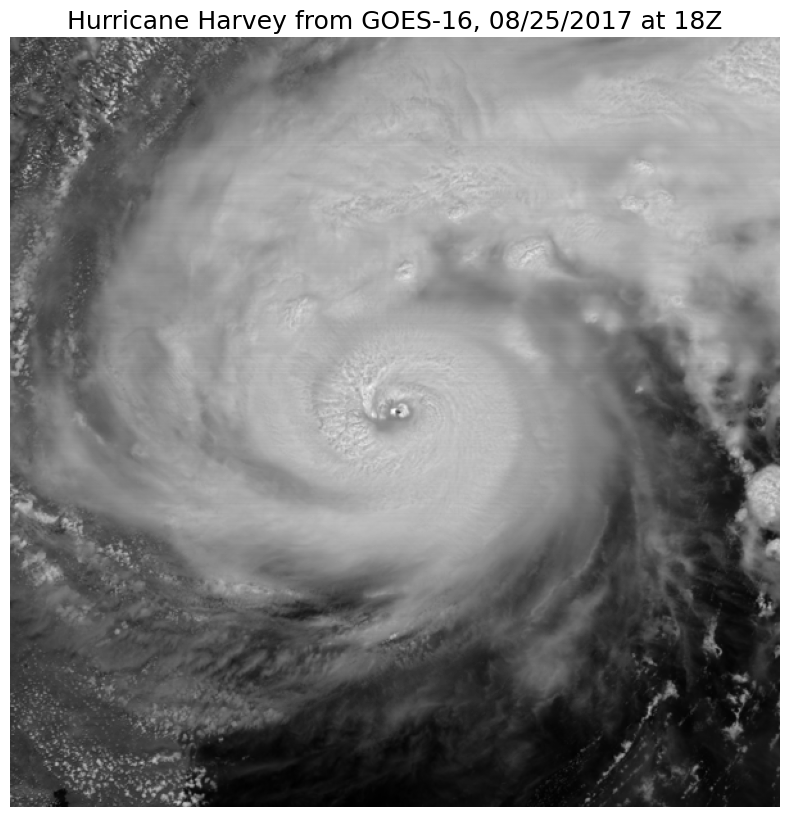

In [6]:
# Get the latitudes/longitudes of the Hurricane Harvey track data
dfTracks = dfTracks[dfTracks['ISO_TIME']==date]
trackLat = dfTracks['LAT'].astype(float)
trackLon = dfTracks['LON'].astype(float)

# Get dataset projection data
satHeight = ds.goes_imager_projection.perspective_point_height
satLon = ds.goes_imager_projection.longitude_of_projection_origin
satSweep = ds.goes_imager_projection.sweep_angle_axis
majorMinorAxes = (ds.goes_imager_projection.semi_major_axis,ds.goes_imager_projection.semi_minor_axis)

# Create a pyproj geostationary map object
p = Proj(proj='geos', h=satHeight, lon_0=satLon, sweep=satSweep)

# Convert lon/lat to x/y
trackX,trackY = p(trackLon,trackLat)

# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
x = ds.variables['x'][:] * satHeight
y = ds.variables['y'][:] * satHeight

# Get the closest point to the IBTrACS data
xInd = np.nanargmin(abs(x-trackX))
yInd = np.nanargmin(abs(y-trackY))

# Plot a cropped with a buffer around the closest point of the storm
buffer = 300
plt.figure(figsize=(10,10));
plt.imshow(ds.Rad[yInd-buffer:yInd+buffer,xInd-buffer:xInd+buffer], cmap='gray'); 
plt.axis('off');
plt.title('Hurricane Harvey from GOES-16, '+date.strftime("%m/%d/%Y")+" at "+str(date.hour)+"Z",fontsize=18);